In [1]:
import freesasa
import re
import networkx as nx
from Bio.PDB.NeighborSearch import NeighborSearch
from Bio.PDB import PDBParser
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans, vq
import numpy as np
import pandas as pd
import os

In [2]:
# 解析加载结构

# 指定你的本地PDB文件路径
pdb_file = './protein_pop1.pdb'

# 解析结构
parser = PDBParser(QUIET=True)  # QUIET=True抑制警告
structure = parser.get_structure('MY_PROTEIN', pdb_file)

# 只处理第一个模型（忽略多个，如果是NMR）
model = structure[0]  # 取第一个模型

# 提取残基信息：打印残基ID、名称、总数
residues = list(model.get_residues())
print(f"Total residues: {len(residues)}")
for res in residues[:10]:  # 只打印前10个测试
    print(f"Residue ID: {res.id[1]}, Name: {res.get_resname()}")

# 提取原子坐标示例（用于后续接触计算）
for res in residues[:5]:  # 前5个
    print(f"Residue {res.id[1]} atoms:")
    for atom in res:
        print(f"  Atom {atom.name}: coord {atom.coord}")


Total residues: 399
Residue ID: 26, Name: HIS
Residue ID: 27, Name: PRO
Residue ID: 28, Name: GLU
Residue ID: 29, Name: THR
Residue ID: 30, Name: LEU
Residue ID: 31, Name: VAL
Residue ID: 32, Name: LYS
Residue ID: 33, Name: VAL
Residue ID: 34, Name: LYS
Residue ID: 35, Name: ASP
Residue 26 atoms:
  Atom N: coord [18.376  1.585 34.443]
  Atom CA: coord [18.239  1.879 35.857]
  Atom C: coord [16.723  2.038 36.064]
  Atom O: coord [16.098  2.547 35.151]
  Atom CB: coord [18.991  3.19  36.175]
  Atom CG: coord [18.924  3.605 37.64 ]
  Atom ND1: coord [17.946  4.227 38.317]
  Atom CD2: coord [19.891  3.248 38.559]
  Atom CE1: coord [18.269  4.228 39.597]
  Atom NE2: coord [19.439  3.637 39.728]
Residue 27 atoms:
  Atom N: coord [16.025  1.708 37.15 ]
  Atom CA: coord [14.572  1.869 37.253]
  Atom C: coord [14.064  3.313 37.135]
  Atom O: coord [12.908  3.551 36.775]
  Atom CB: coord [14.225  1.235 38.59 ]
  Atom CG: coord [15.426  0.428 39.021]
  Atom CD: coord [16.594  1.134 38.371]
Residu

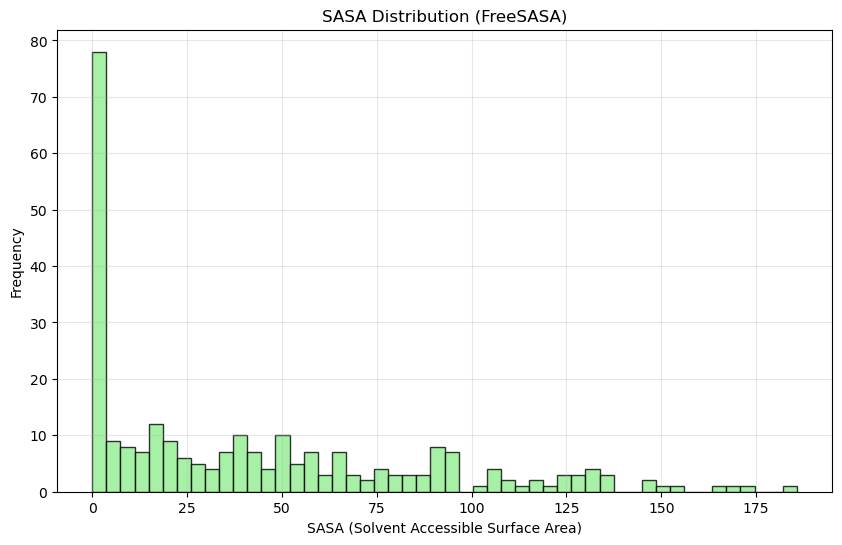

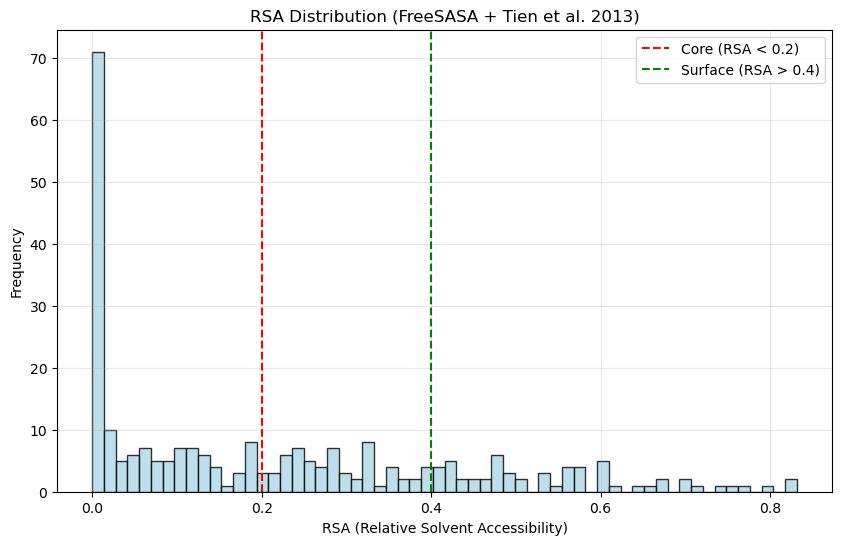

Total residues: 263
Average RSA: 0.214
Core (RSA < 0.2): 146
Surface (RSA > 0.4): 57


In [3]:
# 计算RSA

# 1. 加载并计算SASA（你已成功）
fs_structure = freesasa.Structure(pdb_file)
result = freesasa.calc(fs_structure)
areas = result.residueAreas()

# plot histogram of SASA values
sasa_values = []
for chain in areas:
    for res_key in areas[chain]:
        sasa = areas[chain][res_key].total
        sasa_values.append(sasa)
plt.figure(figsize=(10, 6))
plt.hist(sasa_values, bins=50, color='lightgreen', edgecolor='black', alpha=0.8)
plt.xlabel('SASA (Solvent Accessible Surface Area)')
plt.ylabel('Frequency')
plt.title('SASA Distribution (FreeSASA)')
plt.grid(True, alpha=0.3)
plt.show()

# # print all sasa values for debugging
# print("SASA values for all residues:")
# for chain in areas:
#     for res_key in areas[chain]:
#         sasa = areas[chain][res_key].total
#         print(f"Chain {chain}, Residue {res_key}: SASA = {sasa}")

max_sasa = {
    'ALA': 129.0, 'ARG': 274.0, 'ASN': 195.0, 'ASP': 193.0,
    'CYS': 167.0, 'GLN': 225.0, 'GLU': 223.0, 'GLY': 104.0,
    'HIS': 224.0, 'ILE': 197.0, 'LEU': 201.0, 'LYS': 236.0,
    'MET': 224.0, 'PHE': 240.0, 'PRO': 159.0, 'SER': 155.0,
    'THR': 172.0, 'TRP': 285.0, 'TYR': 263.0, 'VAL': 174.0,
}

# 3. 计算 RSA
rsa_dict = {}
rsa_values = []

for chain in areas:
    for res_key in areas[chain]:
        area = areas[chain][res_key]
        res_type = area.residueType  # 属性，不是方法！
        sasa = area.total
        
        # 使用标准表
        max_val = max_sasa.get(res_type, 150.0)
        rsa = sasa / max_val if max_val > 0 else 0.0
        
        # 提取残基号（支持 51A）
        match = re.search(r'\d+', res_key.strip())
        res_id = int(match.group()) if match else -1
        
        if res_id != -1:
            rsa_dict[res_id] = rsa
            rsa_values.append(rsa)

# 4. 画分布图
plt.figure(figsize=(10, 6))
plt.hist(rsa_values, bins=60, color='lightblue', edgecolor='black', alpha=0.8)
plt.axvline(0.2, color='red', linestyle='--', label='Core (RSA < 0.2)')
plt.axvline(0.4, color='green', linestyle='--', label='Surface (RSA > 0.4)')
plt.xlabel('RSA (Relative Solvent Accessibility)')
plt.ylabel('Frequency')
plt.title('RSA Distribution (FreeSASA + Tien et al. 2013)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 5. 统计
print(f"Total residues: {len(rsa_values)}")
print(f"Average RSA: {np.mean(rsa_values):.3f}")
print(f"Core (RSA < 0.2): {sum(1 for r in rsa_values if r < 0.2)}")
print(f"Surface (RSA > 0.4): {sum(1 for r in rsa_values if r > 0.4)}")


In [4]:
# 生成 PyMOL 脚本进行可视化
pml_file = "rsa_color.pml"
with open(pml_file, 'w') as f:
    f.write(f"load {pdb_file}\n")
    f.write("hide all; show cartoon; color gray90\n")
    f.write("alter all, b=0.0\n")
    for rid, rsa in rsa_dict.items():
        f.write(f"alter resi {rid}, b={rsa}\n")
    f.write("spectrum b, blue_white_red, all\n")
    
    # 高分辨率设置
    f.write("set ray_trace_mode, 1\n")
    f.write("set ray_shadows, 0\n")
    f.write("set antialias, 3\n")
    f.write("set depth_cue, 0\n")
    
    # 图例（连续色条）
    f.write("pseudoatom legend, pos=[0,0,0]\n")
    f.write("spectrum b, blue_white_red, legend, minimum=0, maximum=1\n")
    f.write("show label, legend\n")
    f.write("set label_position, [10, 5, 0]\n")
    f.write("label legend, 'RSA'\n")
    f.write("set label_color, black\n")
    f.write("set label_size, 20\n")
    
    # 导出 300 DPI 高清图（2000x2000）
    f.write("viewport 2000, 2000\n")
    f.write("ray 2000, 2000\n")
    f.write("png rsa_structure_highres.png, dpi=300\n")






print(f"成功生成: {os.path.abspath(pml_file)}")

成功生成: /mnt/c/Users/20145/Desktop/kinetics/rsa_color.pml


Contact graph: 398 nodes, 2134 edges
Residue 26: Closeness = 0.203
Residue 27: Closeness = 0.187
Residue 28: Closeness = 0.196
Residue 29: Closeness = 0.225
Residue 30: Closeness = 0.213
Residue 31: Closeness = 0.196
Residue 32: Closeness = 0.210
Residue 33: Closeness = 0.223
Residue 34: Closeness = 0.204
Residue 35: Closeness = 0.206
Residue 36: Closeness = 0.219
Residue 37: Closeness = 0.223
Residue 38: Closeness = 0.197
Residue 39: Closeness = 0.205
Residue 40: Closeness = 0.227
Residue 41: Closeness = 0.216
Residue 42: Closeness = 0.227
Residue 43: Closeness = 0.254
Residue 44: Closeness = 0.259
Residue 45: Closeness = 0.260
Residue 46: Closeness = 0.259
Residue 47: Closeness = 0.255
Residue 48: Closeness = 0.242
Residue 49: Closeness = 0.243
Residue 50: Closeness = 0.235
Residue 51: Closeness = 0.246
Residue 52: Closeness = 0.221
Residue 53: Closeness = 0.224
Residue 54: Closeness = 0.208
Residue 55: Closeness = 0.215
Residue 56: Closeness = 0.220
Residue 58: Closeness = 0.217
Res

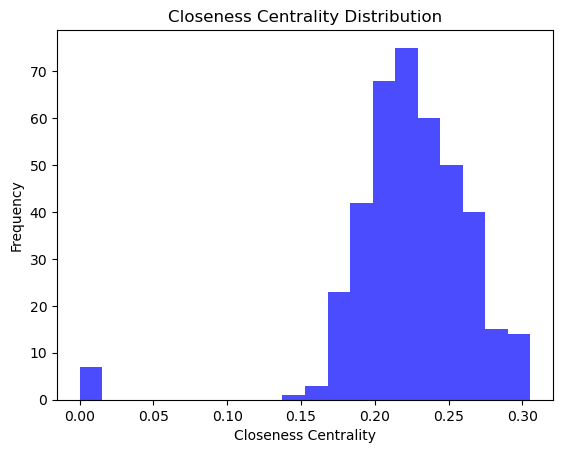

In [ ]:
# contact graph
# 从上步的model
atoms = [atom for res in residues for atom in res if atom.element != 'H']  # 重原子（non-H）

# NeighborSearch找<5 Å残基对
ns = NeighborSearch(atoms)
pairs = ns.search_all(5.0, level='R')  # R=残基水平

# 构建Graph
G = nx.Graph()
for res in residues:
    G.add_node(res.id[1], resname=res.get_resname())  # 节点=残基ID

for res1, res2 in pairs:
    id1, id2 = res1.id[1], res2.id[1]
    if id1 != id2:  # 避免自环
        G.add_edge(id1, id2)

print(f"Contact graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# 计算closeness centrality
closeness = nx.closeness_centrality(G)
closeness_dict = {}
for res_id, cent in sorted(closeness.items()):
    closeness_dict[res_id] = cent
    print(f"Residue {res_id}: Closeness = {cent:.3f}")

print(f"Total closeness calculated: {len(closeness_dict)}")
# check distribution of closeness
# histogram of closeness
closeness_values = list(closeness_dict.values())
plt.hist(closeness_values, bins=20, color='blue', alpha=0.7)
plt.title('Closeness Centrality Distribution')
plt.xlabel('Closeness Centrality')
plt.ylabel('Frequency')
plt.show()

# visualize the contact graph with closeness coloring

# filter out nodes with zero closeness (isolated nodes)
filtered_nodes = [n for n in G.nodes() if closeness_dict[n] > 0.0]
G = G.subgraph(filtered_nodes)

# 高亮活性位点 70 和 166（红色星号 + 标签）
pos = nx.spring_layout(G, seed=42)  # 固定布局
node_colors = [closeness_dict[n] for n in G.nodes()]
plt.figure(figsize=(12, 10))
nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.viridis, node_size=15)
nx.draw_networkx_edges(G, pos, alpha=0.1)
# nx.draw_networkx_labels(G, pos, font_size=8)
# highlight residues 70 and 166
nx.draw_networkx_nodes(G, pos, nodelist=[70, 166], node_shape='*', node_color='red', node_size=15, label='Active Sites')
# nx.draw_networkx_labels(G, pos, labels={70: '70*', 166: '166*'}, font_color='black', font_size=5)
plt.colorbar(nodes, label='Closeness Centrality')
plt.title('Contact Graph Colored by Closeness Centrality')
plt.legend()


# save figure
plt.savefig('./figures/contact_graph_closeness.png', dpi=500)
plt.show()


First neighbors of active sites [70, 166]: [68, 69, 70, 71, 72, 73, 74, 103, 130, 132, 135, 136, 164, 165, 166, 167, 168, 169, 170, 234, 235, 236, 237, 291, 292, 293, 295]


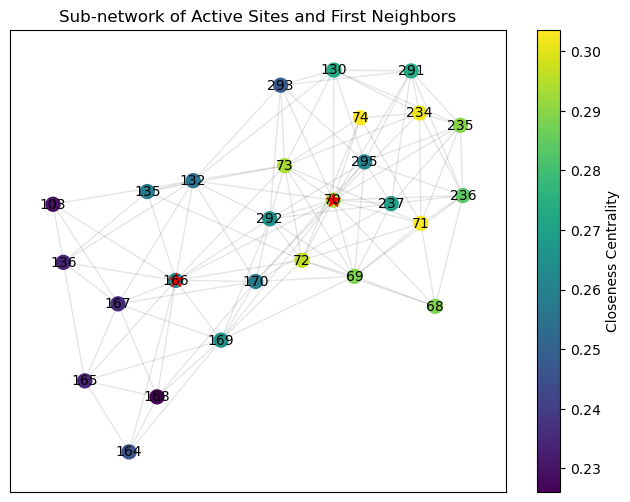

In [33]:
# fetch the first neighbors of active sites 70 and 166
active_sites = [70, 166]
first_neighbors = set()
for site in active_sites:
    neighbors = list(G.neighbors(site))
    first_neighbors.update(neighbors)
print(f"First neighbors of active sites {active_sites}: {sorted(first_neighbors)}")
# visualize the sub-network of active sites and their first neighbors
sub_nodes = active_sites + list(first_neighbors)
sub_G = G.subgraph(sub_nodes)
sub_pos = nx.spring_layout(sub_G, seed=42)
sub_node_colors = [closeness_dict[n] for n in sub_G.nodes()]
plt.figure(figsize=(8, 6))
sub_nodes_drawn = nx.draw_networkx_nodes(sub_G, sub_pos, node_color=sub_node_colors, cmap=plt.cm.viridis, node_size=100)
nx.draw_networkx_edges(sub_G, sub_pos, alpha=0.1)
nx.draw_networkx_labels(sub_G, sub_pos, font_size=10)
# draw active sites with star shape
nx.draw_networkx_nodes(sub_G, sub_pos, nodelist=active_sites, node_shape='*', node_color='red', node_size=100, label='Active Sites')
# nx.draw_networkx_labels(sub_G, sub_pos, labels={site: f"{site}*" for site in active_sites}, font_color='black', font_size=12)


plt.colorbar(sub_nodes_drawn, label='Closeness Centrality')
plt.title('Sub-network of Active Sites and First Neighbors')
plt.savefig('./figures/subnetwork_active_sites.png', dpi=500)
plt.show()

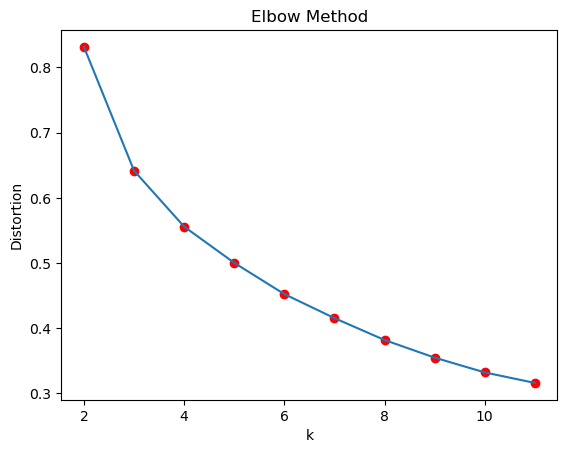

Cluster 0: Residues [68, 69, 70, 71, 72, 73, 74, 75, 127, 186, 190, 211, 233, 234, 235, 236, 244, 245, 246, 247, 262, 264] (count: 22)
Cluster 1: Residues [26, 27, 28, 31, 34, 38, 39, 41, 51, 54, 55, 63, 86, 87, 88, 90, 92, 94, 96, 98, 99, 100, 104, 110, 111, 114, 115, 140, 143, 146, 154, 158, 174, 175, 197, 201, 202, 227, 228, 254, 255, 256, 269, 271, 273, 288] (count: 46)
Cluster 2: Residues [43, 52, 56, 59, 61, 62, 64, 85, 93, 103, 105, 120, 121, 124, 147, 149, 150, 153, 156, 161, 163, 165, 167, 168, 171, 173, 177, 178, 188, 192, 195, 198, 200, 205, 209, 212, 213, 215, 218, 219, 223, 240, 241, 257, 258, 267, 272, 274, 277, 281, 284, 290] (count: 52)
Cluster 3: Residues [48, 49, 50, 60, 65, 79, 80, 81, 82, 122, 125, 128, 129, 131, 132, 133, 134, 136, 137, 138, 142, 151, 155, 157, 159, 164, 170, 172, 180, 182, 184, 191, 196, 199, 204, 206, 208, 216, 222, 224, 225, 230, 237, 238, 242, 251, 259, 266, 275, 276, 280, 282, 283] (count: 53)
Cluster 4: Residues [29, 30, 32, 33, 35, 36, 37, 4

In [30]:
# cluter

# 从上步的rsa_dict, closeness_dict
res_ids = sorted(set(rsa_dict.keys()) & set(closeness_dict.keys()))
features = np.array([[rsa_dict[rid], closeness_dict[rid]] for rid in res_ids])

# 标准化
features = (features - features.mean(axis=0)) / features.std(axis=0)

# 肘部法选k（尝试2-12）
distortions = []
for k in range(2, 12):
    centroids, dist = kmeans(features, k)
    distortions.append(dist)

plt.plot(range(2, 12), distortions)
# add points
plt.scatter(range(2, 12), distortions, color='red')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()  # 看"肘部"选k (e.g., 4-6)

k = 6  # 改成你的选择
centroids, _ = kmeans(features, k)
cluster_labels, _ = vq(features, centroids)

# 输出簇
clusters = {i: [] for i in range(k)}
for i, label in enumerate(cluster_labels):
    clusters[label].append(res_ids[i])

for cl, res_list in clusters.items():
    print(f"Cluster {cl}: Residues {sorted(res_list)} (count: {len(res_list)})")

print("Clustering done. Prioritize clusters: e.g., low RSA + high closeness for cores.")

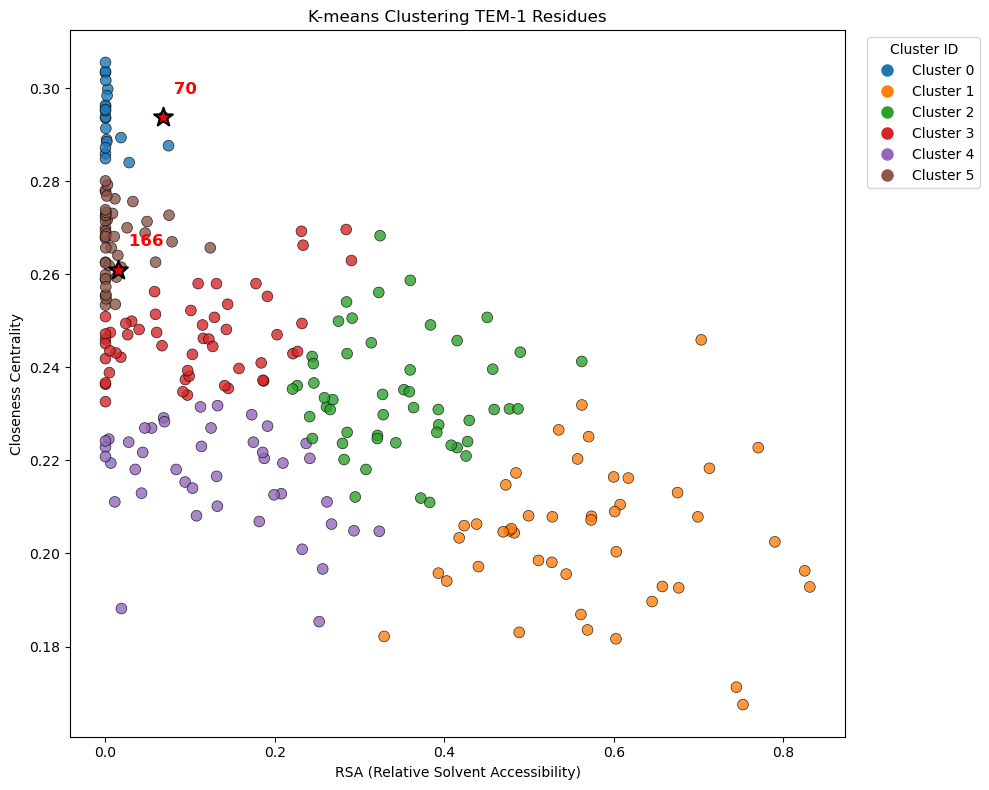

In [35]:
# 可视化
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 原始数据
x = [rsa_dict[rid] for rid in res_ids]
y = [closeness_dict[rid] for rid in res_ids]
colors = cluster_labels  # 簇标签

# 离散颜色（每个簇一种色）
cmap = plt.get_cmap('tab10')  # 最多10种颜色
norm_colors = [cmap(i) for i in colors]

# 散点图
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(x, y, c=norm_colors, s=60, alpha=0.8, edgecolors='k', linewidth=0.5)

# 高亮活性位点 70 和 166（红色星号 + 标签）
active_sites = [70, 166]
for site in active_sites:
    if site in res_ids:
        idx = res_ids.index(site)
        ax.scatter(x[idx], y[idx], c='red', s=200, marker='*', edgecolors='black', linewidth=1.5)
        ax.text(x[idx] + 0.005, y[idx] + 0.005, f' {site}', fontsize=12, fontweight='bold', color='red')

# 颜色条（显示簇ID）
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10) 
           for i in range(len(set(colors)))]
ax.legend(handles, [f'Cluster {i}' for i in range(len(set(colors)))], 
          title='Cluster ID', loc='upper left', bbox_to_anchor=(1.02, 1))

# 轴标签和标题
ax.set_xlabel('RSA (Relative Solvent Accessibility)')
ax.set_ylabel('Closeness Centrality')
ax.set_title('K-means Clustering TEM-1 Residues')

plt.tight_layout()
# 保存（可选）
plt.savefig('./figures/tem1_clustering_discrete_active.png', dpi=300)

plt.show()


In [41]:
# 生成 PyMOL 脚本将聚类标签映射到颜色，使用与散点图相同的颜色

# 使用与散点图相同的colormap (tab10)
cmap = plt.get_cmap('tab10')

# 创建聚类到PyMOL颜色的映射（转换RGB到PyMOL颜色代码）
cluster_to_pymol_colors = {}
for cluster_id in sorted(set(cluster_labels)):
    # 获取matplotlib颜色
    rgba = cmap(cluster_id)
    # 转换为PyMOL RGB颜色字符串
    r, g, b = rgba[0], rgba[1], rgba[2]
    cluster_to_pymol_colors[cluster_id] = [r, g, b]

# 生成 PyMOL 脚本
cluster_pml_file = "cluster_color.pml"
with open(cluster_pml_file, 'w') as f:
    f.write(f"load {pdb_file}\n")
    f.write("hide all; show cartoon\n")
    f.write("set cartoon_fancy_helices, 1\n")
    f.write("set cartoon_thickness, 0.5\n")
    
    # 为每个聚类的残基着色
    for cluster_id in sorted(set(cluster_labels)):
        # 获取该聚类中的所有残基
        cluster_res_list = [res_ids[i] for i, label in enumerate(cluster_labels) if label == cluster_id]
        rgb = cluster_to_pymol_colors[cluster_id]
        
        # 创建选择
        res_str = '+'.join(map(str, cluster_res_list))
        f.write(f"select cluster_{cluster_id}, resi {res_str}\n")
        f.write(f"set_color cluster_{cluster_id}_color, [{rgb[0]:.3f}, {rgb[1]:.3f}, {rgb[2]:.3f}]\n")
        f.write(f"color cluster_{cluster_id}_color, cluster_{cluster_id}\n")
    
    # 高亮活性位点 - 使用cartoon putty和更大的半径
    f.write("\nselect active_sites, resi 70+166\n")
    f.write("show cartoon, active_sites\n")
    f.write("cartoon putty\n")
    f.write("set cartoon_putty_scale_min, 1.0\n")
    f.write("set cartoon_putty_scale_max, 2.5\n")
    f.write("set cartoon_putty_radius, 0.3\n")
    f.write("set cartoon_putty_quality, 10\n")
    f.write("color red, active_sites\n")
    
    # 添加球体覆盖活性位点残基
    f.write("select active_ca, (resi 70+166) and name CA\n")
    f.write("show sphere, active_ca\n")
    f.write("set sphere_scale, 1.5\n")
    f.write("color red, active_ca\n")
    f.write("set sphere_transparency, 0.3\n")
    
    # 视图设置 - 确保蛋白质完整显示
    f.write("\nset bg_color, white\n")
    f.write("reset\n")  # 重置所有设置
    f.write("zoom all\n")  # 自动缩放到所有原子
    f.write("center\n")  # 居中
    f.write("orient\n")  # 最佳方向
    f.write("set ray_trace_mode, 1\n")
    f.write("set ray_shadows, 0\n")
    f.write("set antialias, 3\n")
    f.write("set depth_cue, 0\n")
    f.write("set orthoscopic, off\n")
    
    # 视口和渲染
    f.write("\nviewport 2000, 2000\n")
    f.write("ray 2000, 2000\n")
    f.write("png cluster_structure_colored.png, dpi=300\n")

print(f"成功生成聚类颜色脚本: {os.path.abspath(cluster_pml_file)}")
print(f"\n聚类颜色映射 (与散点图一致):")
for cluster_id in sorted(set(cluster_labels)):
    rgb = cluster_to_pymol_colors[cluster_id]
    count = sum(1 for label in cluster_labels if label == cluster_id)
    res_list = [res_ids[i] for i, label in enumerate(cluster_labels) if label == cluster_id]
    print(f"  Cluster {cluster_id} RGB({rgb[0]:.3f}, {rgb[1]:.3f}, {rgb[2]:.3f}): {count} residues")

print(f"\n活性位点 (红色突出显示):")
print(f"  Residue 70: {res_name_dict.get(70, 'UNK')}")
print(f"  Residue 166: {res_name_dict.get(166, 'UNK')}")


成功生成聚类颜色脚本: /mnt/c/Users/20145/Desktop/kinetics/cluster_color.pml

聚类颜色映射 (与散点图一致):
  Cluster 0 RGB(0.122, 0.467, 0.706): 22 residues
  Cluster 1 RGB(1.000, 0.498, 0.055): 46 residues
  Cluster 2 RGB(0.173, 0.627, 0.173): 52 residues
  Cluster 3 RGB(0.839, 0.153, 0.157): 53 residues
  Cluster 4 RGB(0.580, 0.404, 0.741): 43 residues
  Cluster 5 RGB(0.549, 0.337, 0.294): 46 residues

活性位点 (红色突出显示):
  Residue 70: SER
  Residue 166: GLU


In [ ]:
# save into .csv

# 创建残基ID到名称的映射
res_name_dict = {}
for res in residues:
    res_id = res.id[1]
    res_name = res.get_resname()
    res_name_dict[res_id] = res_name

# 创建dataframe，包含各残基的特征
data = {
    'Residue_ID': res_ids,
    'Residue_Name': [res_name_dict.get(rid, 'UNK') for rid in res_ids],
    'RSA': [rsa_dict[rid] for rid in res_ids],
    'Closeness_Centrality': [closeness_dict[rid] for rid in res_ids],
    'Cluster': [cluster_labels[i] for i in range(len(res_ids))],
}

df = pd.DataFrame(data)

# 保存为CSV
output_file = './residue_features_clustering.csv'
df.to_csv(output_file, index=False)

print(f"Successfully saved residue features to: {os.path.abspath(output_file)}")
print(f"\nDataFrame summary:")
print(f"Total residues: {len(df)}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst 10 rows:")
print(df.head(10))
print(f"\nCluster distribution:")
print(df['Cluster'].value_counts().sort_index())
print(f"\nStatistics by cluster:")
print(df.groupby('Cluster')[['RSA', 'Closeness_Centrality']].describe())

Successfully saved residue features to: /mnt/c/Users/20145/Desktop/kinetics/residue_features_clustering.csv

DataFrame summary:
Total residues: 262
Columns: ['Residue_ID', 'Residue_Name', 'RSA', 'Closeness_Centrality', 'Cluster']

First 10 rows:
   Residue_ID Residue_Name       RSA  Closeness_Centrality  Cluster
0          26          HIS  0.417511              0.203356        1
1          27          PRO  0.561236              0.186889        1
2          28          GLU  0.392977              0.195771        1
3          29          THR  0.003896              0.224574        4
4          30          LEU  0.207523              0.212846        4
5          31          VAL  0.543821              0.195571        1
6          32          LYS  0.132025              0.210161        4
7          33          VAL  0.000000              0.222876        4
8          34          LYS  0.482561              0.204442        1
9          35          ASP  0.266848              0.206313        4

Clust